In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
outpath = "output/test_effect_size_filter/"

In [63]:
sub = "dummy"
# group = "compartment"
group = "ontology"
# cutoff = 0.3

# sub = "tiss_comp"
# group = "ontology"
cutoff = 0.5

z_col = "scZ"
#
# cutoff = 1.6
# z_col = "svd_z0"

# cutoff = 

dataname1 = "TSP1_10x_with_postprocessing_nopanc_cellann_sharedjuncs_sharedonts_10x"
dataname2 = "TSP2_10x_rerun_with_postprocessing_3prime_cellann_sharedjuncs_sharedonts_10x"

# dataname1 = "TS_pilot_smartseq_with_postprocessing_nopanc_cellann_sharedjuncs_sharedonts_ss2"
# dataname2 = "TSP2_SS2_RUN1_RUN2_cellann_sharedjuncs_sharedonts_ss2"

# cutoff = 3.5

In [64]:
# read in z score files to get median zs
datapath = "../data/"



df1 = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(datapath,dataname1),columns=[z_col,"cell","geneR1A_uniq","ontology","cell_gene","tissue","compartment"])
df2 = pd.read_parquet("{}{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5.pq".format(datapath,dataname2),columns=[z_col,"cell","geneR1A_uniq","ontology","cell_gene","tissue","compartment"])

df1 = df1.drop_duplicates("cell_gene")
df1["ontology_gene"] = df1[group] + df1["geneR1A_uniq"]
df1["med_scZ"] = df1["ontology_gene"].map(df1.groupby('ontology_gene')[z_col].median())
df1 = df1.drop_duplicates("ontology_gene")

df2 = df2.drop_duplicates("cell_gene")
df2["ontology_gene"] = df2[group] + df2["geneR1A_uniq"]
df2["med_scZ"] = df2["ontology_gene"].map(df2.groupby('ontology_gene')[z_col].median())
df2 = df2.drop_duplicates("ontology_gene")

mergedz = df1.merge(df2,on="ontology_gene")

if sub == "tiss_comp":
  mergedz["sub_gene"] = mergedz["tissue_x"] + mergedz["compartment_x"] + mergedz["geneR1A_uniq_x"]
elif sub == "tissue":
  mergedz["sub_gene"] = mergedz["tissue_x"] + mergedz["geneR1A_uniq_x"]
elif sub == "dummy":
  mergedz["sub_gene"] = mergedz["geneR1A_uniq_x"]

In [65]:
df1["tiss_comp_gene"] = df1["tissue"] + df1["compartment"] + df1["geneR1A_uniq"]

In [66]:

df1["min_med"] = df1.groupby("tiss_comp_gene")["med_scZ"].transform("min")
df1["max_med"] = df1.groupby("tiss_comp_gene")["med_scZ"].transform("max")
df1["diff"] = df1["max_med"] - df1["min_med"]
df1["gene_max_diff"] = df1.groupby("geneR1A_uniq")["diff"].transform("max")

In [67]:
df1 = df1[df1["gene_max_diff"] > cutoff]

In [68]:
df1.shape

(20402, 14)

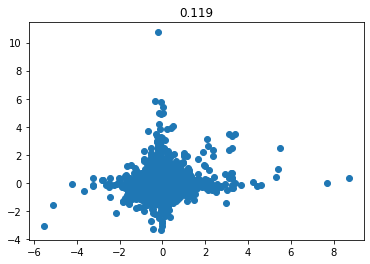

In [69]:
plt.plot(mergedz["med_scZ_x"],mergedz["med_scZ_y"],linestyle="",marker="o")
plt.title("{:0.3f}".format(mergedz["med_scZ_x"].corr(mergedz["med_scZ_y"])))
plt.show()

In [70]:
# read in p value files
datapath = "../data/"
# sub = "tiss_comp"
# group = "ontology"

df1 = pd.read_csv("{}{}_pvals_{}-{}_100_S_0.1_z_0.0_b_5.tsv".format(datapath,dataname1,group,sub),sep="\t")
df2 = pd.read_csv("{}{}_pvals_{}-{}_100_S_0.1_z_0.0_b_5.tsv".format(datapath,dataname2,group,sub),sep="\t")
df1["sub_col"] = df1["sub_col"].fillna("")
df2["sub_col"] = df2["sub_col"].fillna("")
df1["gene_subcol"] = df1["geneR1A_uniq"] + df1["sub_col"]
df2["gene_subcol"] = df2["geneR1A_uniq"] + df2["sub_col"]
merged = df1.merge(df2,on="gene_subcol")
merged["sub_gene"] = merged["sub_col_x"] + merged["geneR1A_uniq_x"]

In [71]:
efs = [x * 0.01 for x in range(400)]
# efs = [x * 0.1 for x in range(20)]
corrs = []
num_genes = []
plot = False
for ef in efs:

  sig_merged = merged[((merged["perm_pval_adj_{}_x".format(z_col)] < 0.05) & (merged["max_abs_median_{}_x".format(z_col)] > ef)) & ((merged["perm_pval_adj_{}_y".format(z_col)] < 0.05)& (merged["max_abs_median_{}_y".format(z_col)] > ef))]
  
  sig_genes = list(sig_merged["geneR1A_uniq_x"].unique())
  sig_subgenes = list(sig_merged["sub_gene"].unique())
  sig_mergedz = mergedz[mergedz["sub_gene"].isin(sig_subgenes)]
  num_genes.append(len(sig_genes))
  corrs.append(sig_mergedz["med_scZ_x"].corr(sig_mergedz["med_scZ_y"]))

  if (ef == cutoff) & (len([x for x in sig_subgenes if str(x) != 'nan']) > 0):
    print(", ".join(sig_subgenes))
    print(", ".join(sig_genes))
#   lskdjf
#   if ef == 0.5:
#     ;slkfj
  if plot:
    plt.plot(sig_mergedz["med_scZ_x"],sig_mergedz["med_scZ_y"],linestyle="",marker="o")

    plt.title("{:0.3f}".format(sig_mergedz["med_scZ_x"].corr(sig_mergedz["med_scZ_y"])))

    plt.show()

PPP1R12A, PNRC1, RBM39, PSMB4, PSAP, RPS19, TPM1, TMSB4X, TPM2, TPM3, RPS27A, RPS24, SNRPB, SNHG8, SMIM25, SEC61G, FYB1, CD47, ATP5F1C, COX4I1, MYL6, NDUFB1, IRF1, LMO7, CD3D, OCIAD2, CIRBP
PPP1R12A, PNRC1, RBM39, PSMB4, PSAP, RPS19, TPM1, TMSB4X, TPM2, TPM3, RPS27A, RPS24, SNRPB, SNHG8, SMIM25, SEC61G, FYB1, CD47, ATP5F1C, COX4I1, MYL6, NDUFB1, IRF1, LMO7, CD3D, OCIAD2, CIRBP


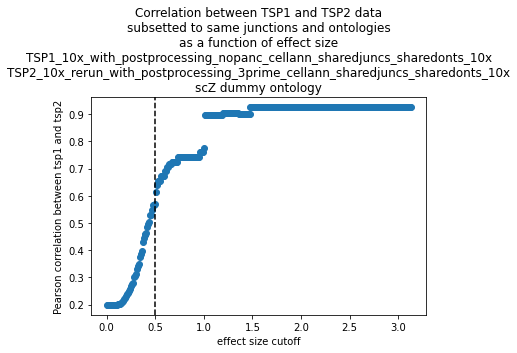

In [72]:
# cutoff = 0.25
plt.plot(efs,corrs,linestyle="",marker="o")
plt.xlabel("effect size cutoff")
plt.ylabel("Pearson correlation between tsp1 and tsp2")
plt.title("Correlation between TSP1 and TSP2 data\nsubsetted to same junctions and ontologies\nas a function of effect size\n{}\n{}\n{} {} {}".format(dataname1,dataname2,z_col, sub, group))
plt.axvline(x=cutoff,color="k",linestyle="--")
# plt.savefig("{}_concord.png".format(outpath),bbox_inches="tight")
plt.savefig("{}concord_{}_{}.png".format(outpath,z_col, cutoff),bbox_inches="tight")


plt.show()

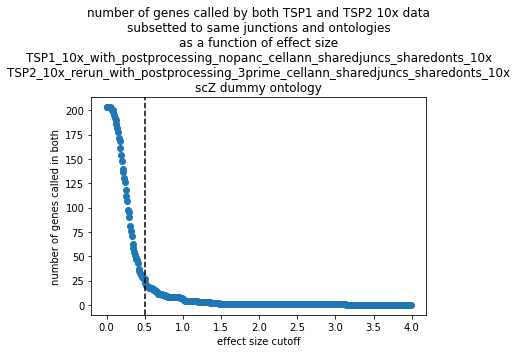

In [73]:

plt.plot(efs,num_genes,linestyle="",marker="o")
plt.xlabel("effect size cutoff")
plt.ylabel("number of genes called in both")
plt.title("number of genes called by both TSP1 and TSP2 10x data\nsubsetted to same junctions and ontologies\nas a function of effect size\n{}\n{}\n{} {} {}".format(dataname1,dataname2,z_col, sub, group))
plt.axvline(x=cutoff,color="k",linestyle="--")
plt.savefig("{}numgenes_{}_{}.png".format(outpath,z_col, cutoff),bbox_inches="tight")
# plt.yscale("log")
plt.show()